<a href="https://colab.research.google.com/github/omk42/Pattern-Mining/blob/master/visualizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installations**

In [34]:
!pip install fpdf

  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40720 sha256=0983a4cfe62a47c72bb3efaad2d85fd66bb4db62f2d7b46286fad4e20bbe0a0c
  Stored in directory: /root/.cache/pip/wheels/9a/e9/77/4554ff5c99bc3f487c8d69620d8c41d99d54e9c54ab20ef4c9
Successfully built fpdf


**Libraries**

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
from pathlib import Path
from skimage.util.shape import view_as_windows
from skimage.transform import resize
import scipy.io as sio
import pickle
import random

**Configurations**

In [0]:
conf_patchSize = 48
conf_stepSize = 24

conf_numTopActivation = 20
conf_supp = 0.1
conf_minLength = 16
conf_maxLength = 18
conf_confid = 30


## FOR REMOTE
ROOT = '/content/drive/My Drive/MDPM/'

conf_dataset = 'shoes_trim'
conf_imgDir = ROOT + 'data/' + conf_dataset

conf_output = ROOT + 'output/shoes_trim_fc7/'
conf_cnnFeatures = conf_output + 'cnnFeatures.npy'
conf_imageDict = conf_output + 'imageDict.pkl'
conf_indexImg = conf_output + 'indexImg.pkl'

conf_code = '{}m{}n{}q2'.format(str(conf_supp).replace(".", "p"), conf_minLength, conf_maxLength)
conf_cluster_file = conf_output + 'clusters' + conf_code + '.pkl'

# conf_cluster_file = ROOT + 'output/' + conf_dataset + '/clustersp1m7n9q2.pkl' #Good, lil inaccurate
# conf_cluster_file = ROOT + 'output/' + conf_dataset + '/clustersp08m8n10q2.pkl' #Good, intricate but accurate

conf_results = Path(conf_output + "results/" + conf_code)
conf_results.mkdir()
labels = [x for x in Path(conf_imgDir).iterdir()]

### FOR LOCAL
# ROOT = './MDPM_python/'
# conf_output = ROOT + 'shoes_trim_fc7/'
# conf_cnnFeatures = conf_output + 'cnnFeatures.npy'
# conf_imageDict = conf_output + '/imageDict.pkl'
# conf_indexImg = conf_output + '/indexImg.pkl'
# conf_results = conf_output + "results/"

# conf_code = '{}m{}n{}q2'.format(str(conf_supp).replace(".", "p"), conf_minLength, conf_maxLength)
# conf_cluster_file = conf_output + 'clusters' + conf_code + '.pkl'

In [0]:
with open(conf_cluster_file, 'rb') as f:
  clusters = pickle.load(f)

with open(conf_indexImg, 'rb') as f:
  indexImg = np.array(pickle.load(f))

with open(conf_imageDict, 'rb') as f:
  imageDict = pickle.load(f)

In [0]:
def sample_images (im_path, patchSize):
  I = plt.imread(im_path)
  if I.dtype == np.uint8:
    I = I.astype('<f')
  # print (np.mean(I, (0,1)))
  imHeight, imWidth, imDepth = I.shape
  if imHeight > imWidth:
    new_ht = int((256/float(imWidth))*imHeight)
    I = resize(I, (new_ht, 256))
  else:
    new_width = int((256/float(imHeight)) * imWidth)
    I = resize(I, (256, new_width))
  
  patches = view_as_windows(I, (patchSize, patchSize,3), step=conf_stepSize)
  return patches

Create a mosaic

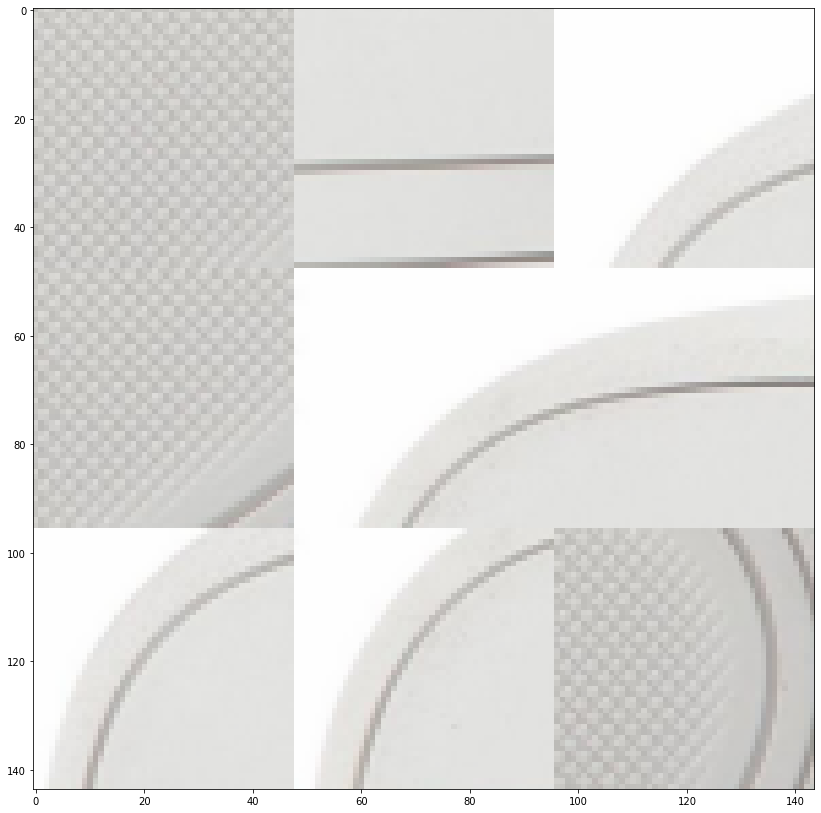

5167


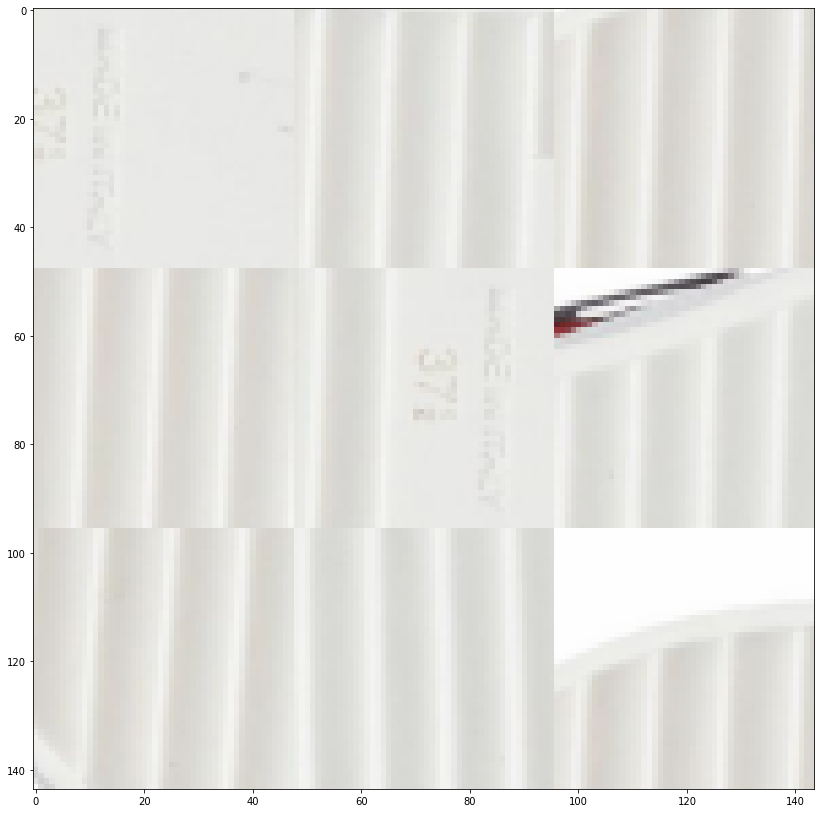

7437


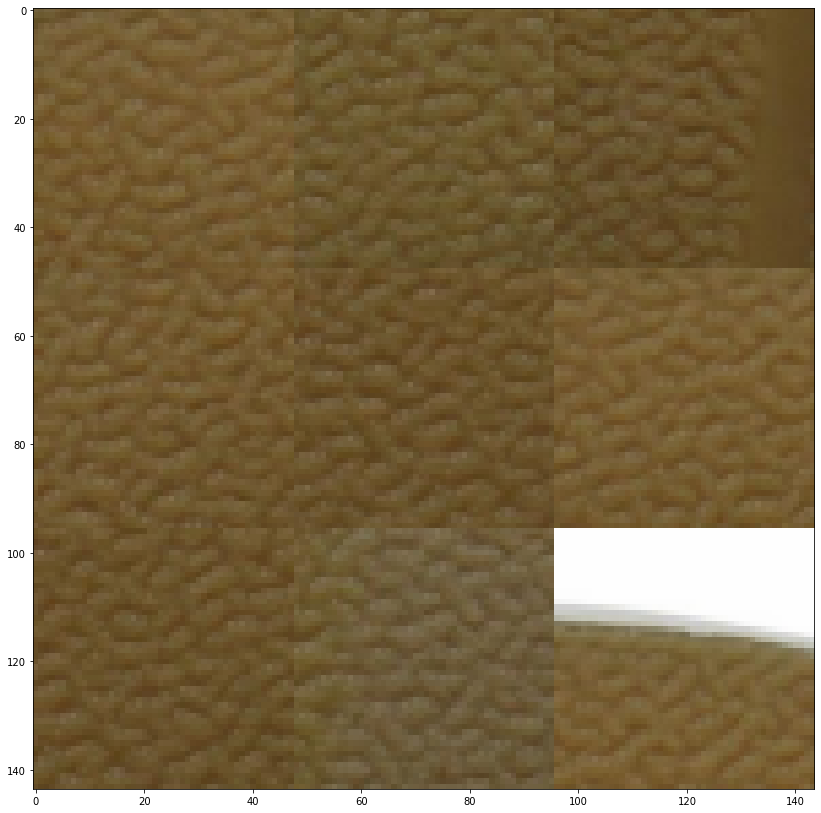

13180


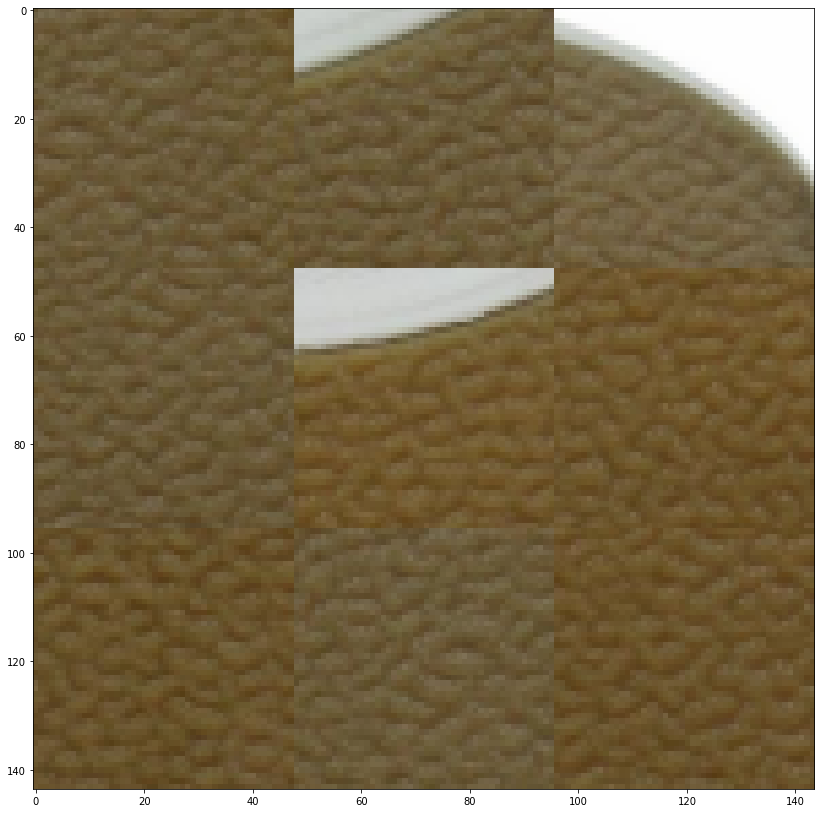

7082


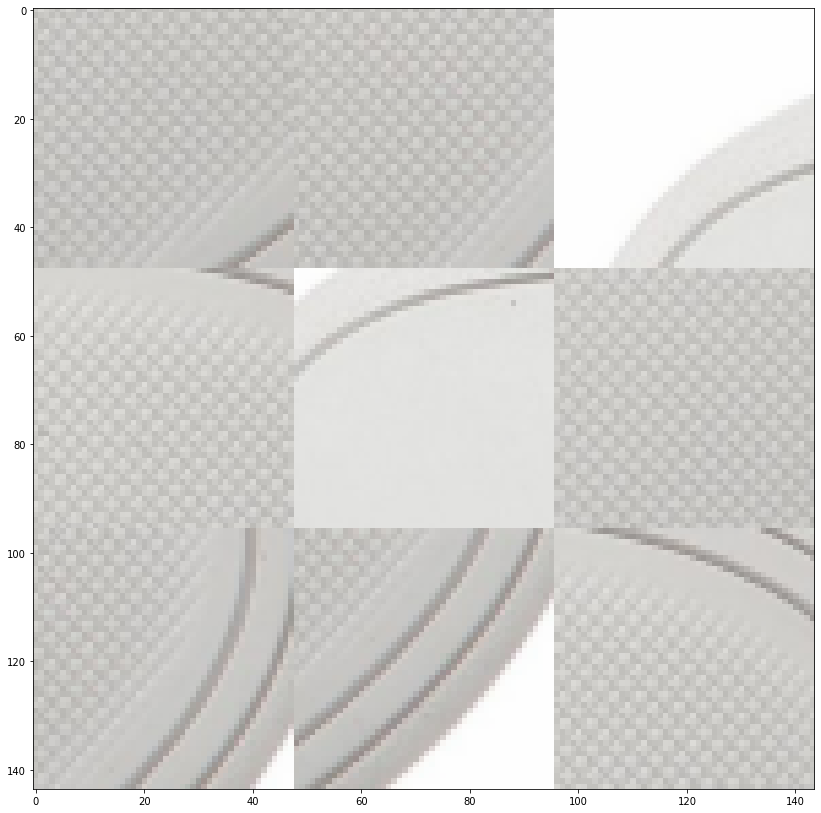

5842


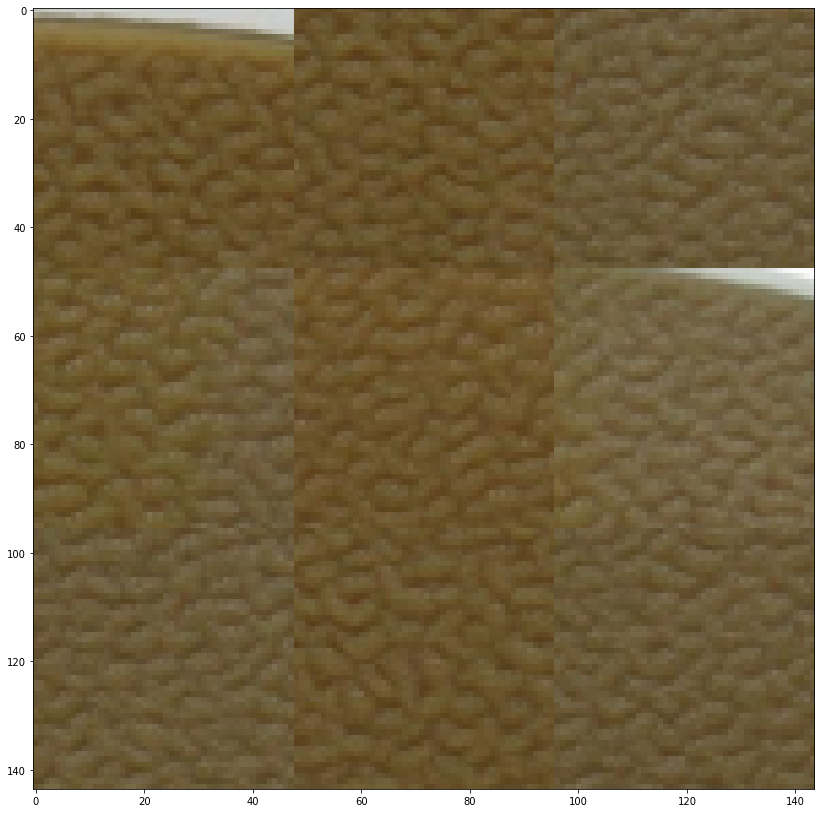

4052


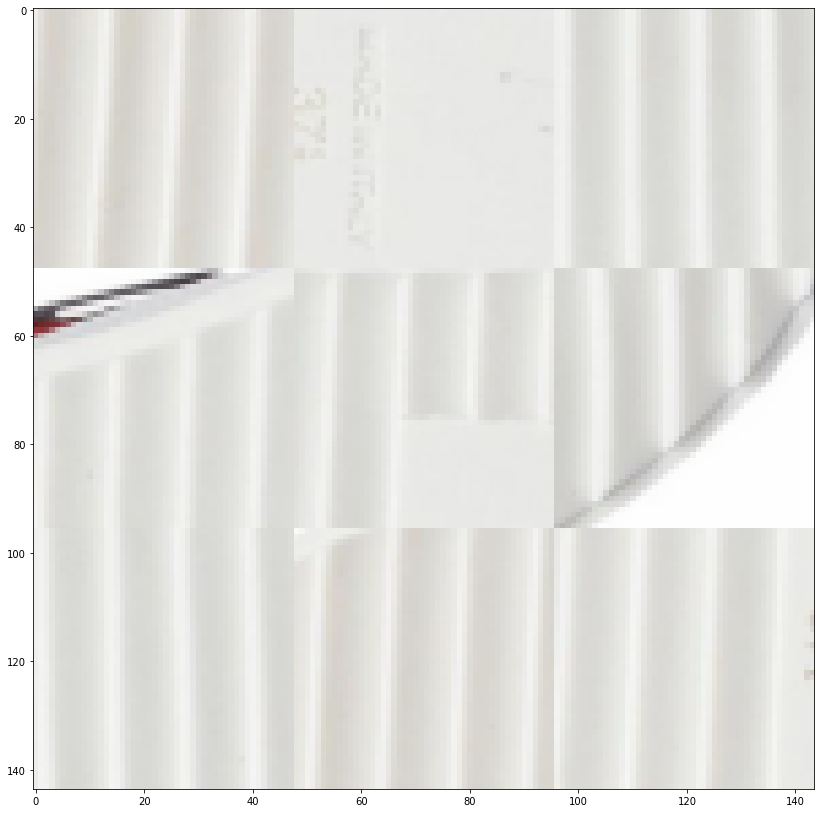

185


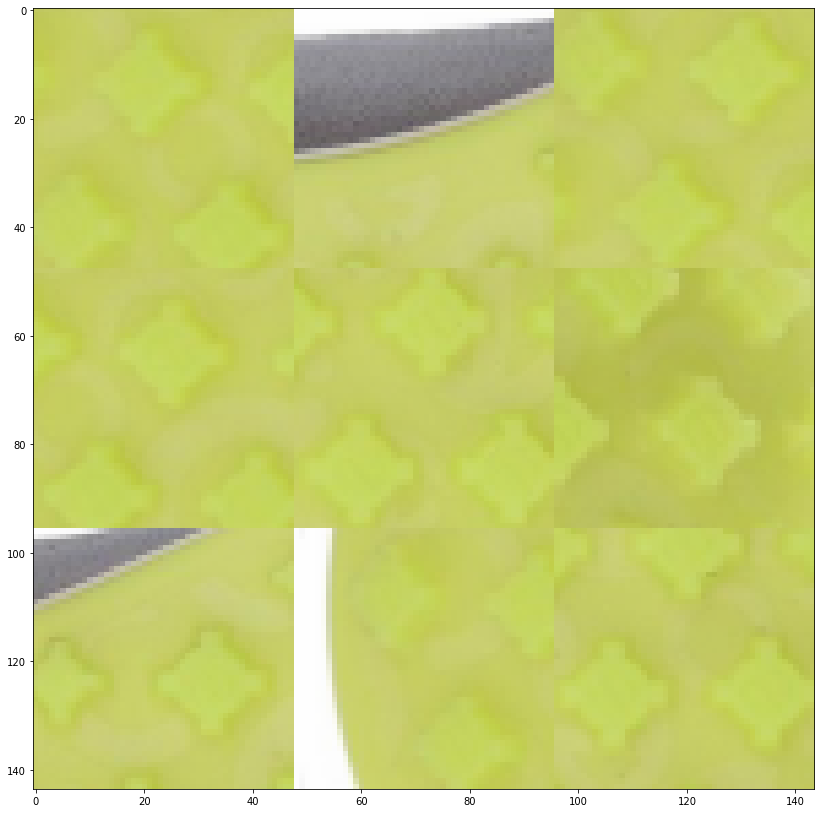

13623


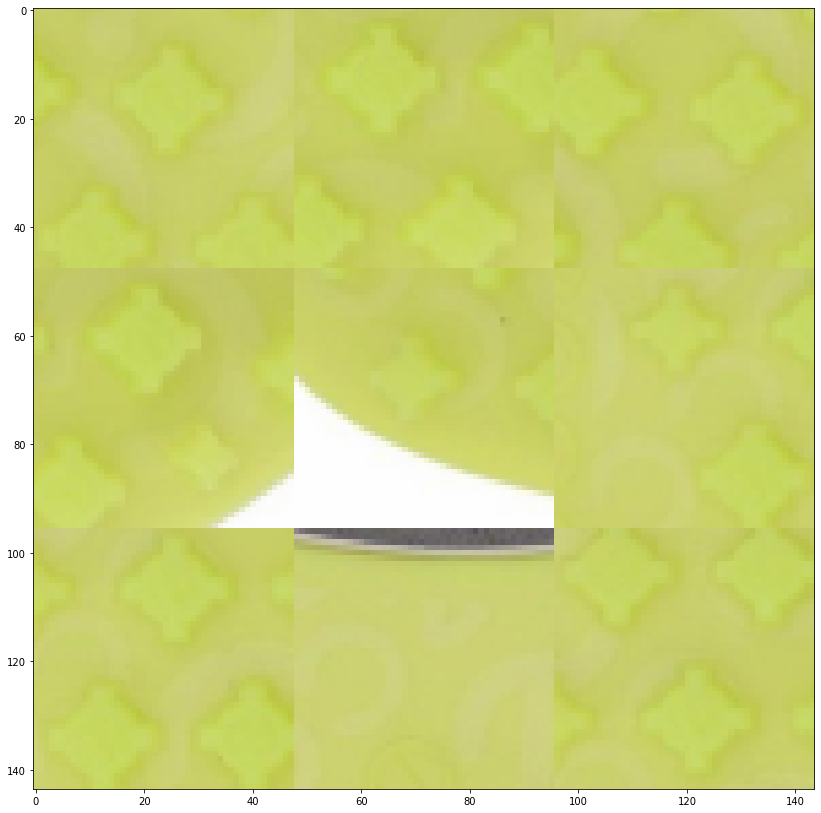

11903


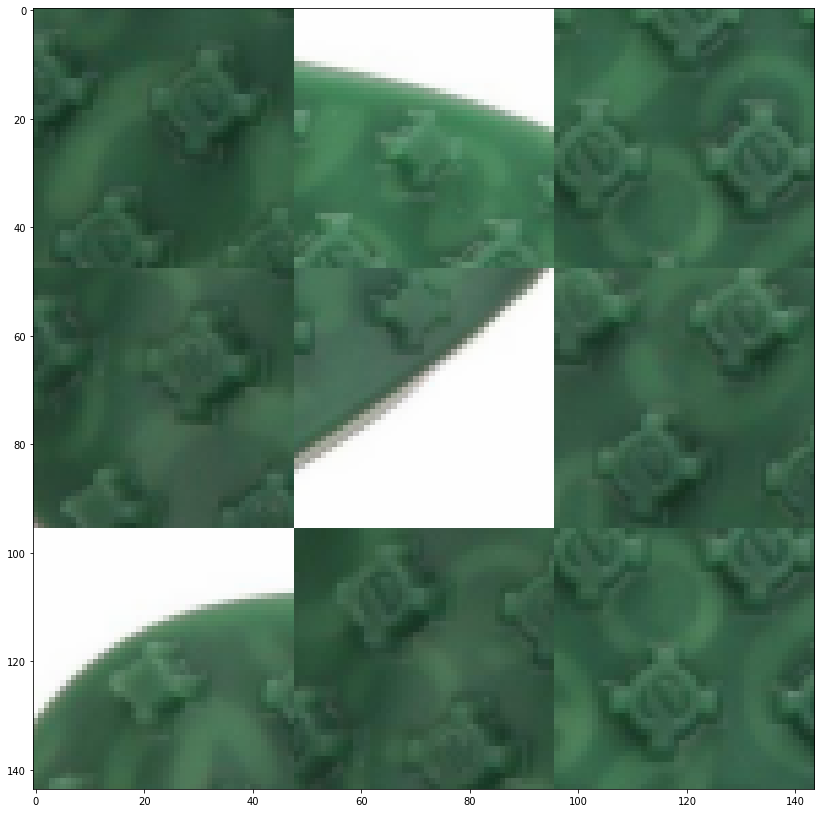

141


In [94]:
# max_clust = max(clusters, key=len)
clust_size = 3

for _ in range(10):
  clustID = random.randint(0,len(clusters)-1)
  max_clust = clusters[clustID]
  # max_clust = np.random.choice(clusters)
  # for max_clust in clusters:
  # max_clust = clusters[0]
  rand_clust = np.random.choice(max_clust, clust_size**2, replace=False)

  # images_id = indexImg[rand_clust]
  # print (rand_clust, images_id)

  # fig = plt.figure()
  # plt.rcParams['figure.figsize'] = [5, 5]

  mosaic = np.zeros((clust_size*conf_patchSize, clust_size*conf_patchSize, 3))

  for patch_num, patch in enumerate(rand_clust):
    mosaic_ht = patch_num // clust_size
    mosaic_wd = patch_num % clust_size
    
    image_id = indexImg[patch]
    first_patch = np.where(indexImg == image_id)[0][0]
    num_patch = patch-first_patch+1
    
    patches = sample_images(imageDict[image_id], conf_patchSize)

    k = 1 
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        if k == num_patch:
          # ax1 = fig.add_subplot(1,5,patch_num+1)
          mosaic[mosaic_ht*conf_patchSize: (mosaic_ht+1)*conf_patchSize, mosaic_wd*conf_patchSize: (mosaic_wd+1)*conf_patchSize, :] = patches[i][j][0]/256
        k += 1

  plt.rcParams['figure.figsize'] = [14, 19]
  plt.imshow(mosaic, cmap=plt.cm.cool)
  plt.show()

  print (clustID)

Store multiple mosaics in a pdf 

In [95]:
from fpdf import FPDF

mosaic_num = 10
clust_size = 5

pdf = FPDF()
pdf.set_font('Arial', '', 14)

clusts = [7471, 5173, 3159, 10299, 7324, 4343, 7082, 141]
# for _ in range(mosaic_num):
#   pdf.add_page()

# for mosaicID in range (mosaic_num):
for clustID in clusts:
  # clustID = random.randint(0,len(clusters)-1)
  max_clust = clusters[clustID]
  if max_clust.size < clust_size**2:
    continue
  rand_clust = np.random.choice(max_clust, clust_size**2, replace=False)

  mosaic = np.zeros((clust_size*conf_patchSize, clust_size*conf_patchSize, 3))

  for patch_num, patch in enumerate(rand_clust):
    mosaic_ht = patch_num // clust_size
    mosaic_wd = patch_num % clust_size
    
    image_id = indexImg[patch]
    first_patch = np.where(indexImg == image_id)[0][0]
    num_patch = patch-first_patch+1
    
    patches = sample_images(imageDict[image_id], conf_patchSize)

    k = 1 
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        if k == num_patch:
          mosaic[mosaic_ht*conf_patchSize: (mosaic_ht+1)*conf_patchSize, mosaic_wd*conf_patchSize: (mosaic_wd+1)*conf_patchSize, :] = patches[i][j][0]/256
        k += 1
  with open(str(conf_results) + "/" + str(clustID) + '.png', 'wb') as f:
    plt.imsave(f, mosaic)
  pdf.add_page()
  pdf.image(str(conf_results) + "/" + str(clustID) + '.png', 50, 50)
  pdf.write(5,"Cluster {}/{} contains {} patches".format(clustID, len(clusters), len(max_clust)))
pdf.output(str(conf_results) + "/" + 'mosaics.pdf', 'F')


''

Visualize patches in a cluster

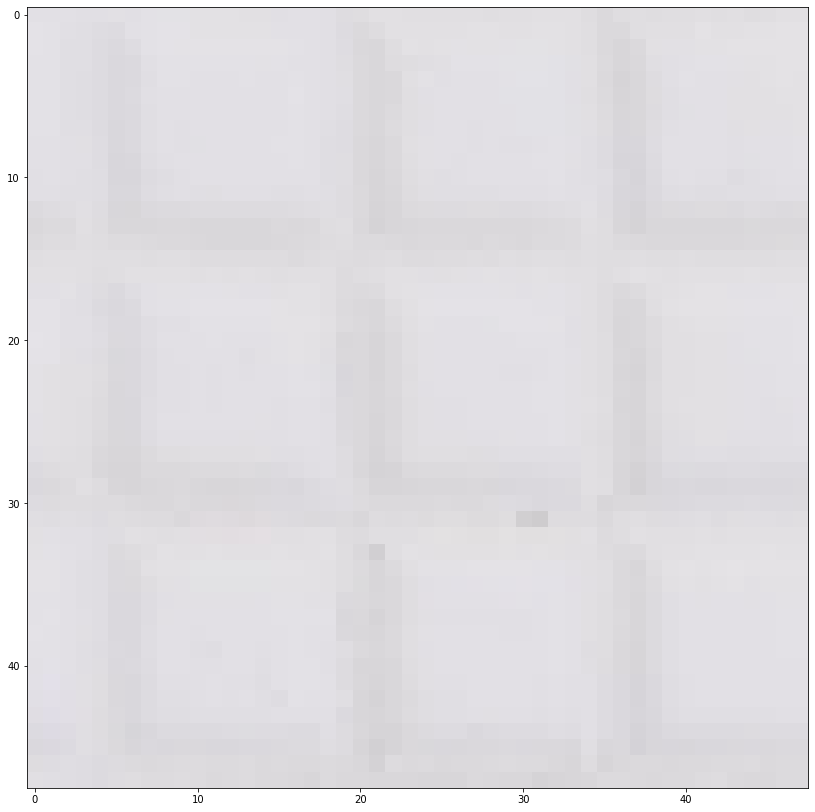

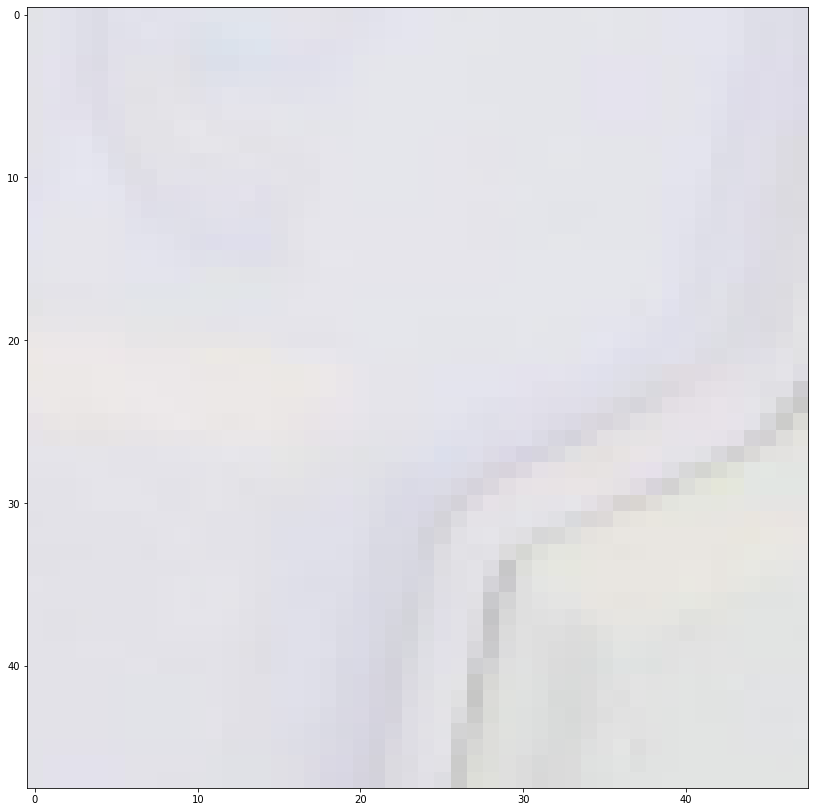

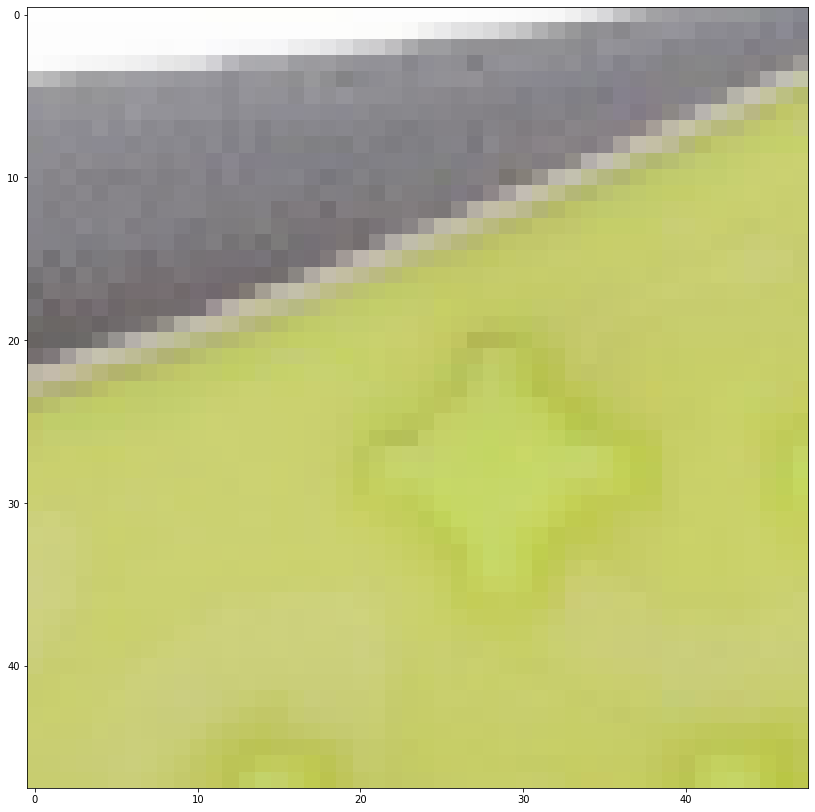

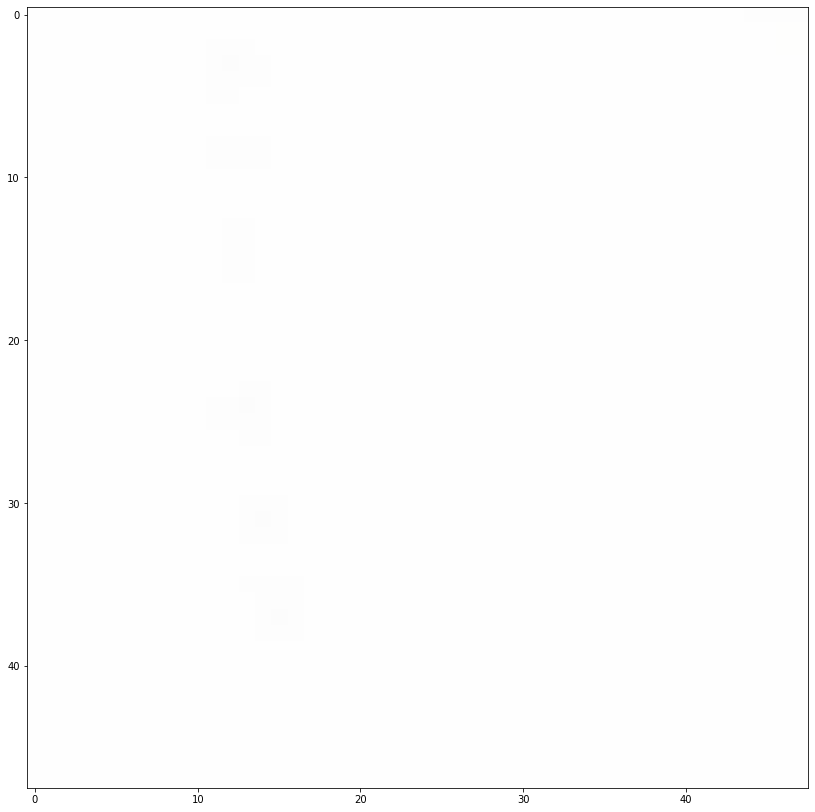

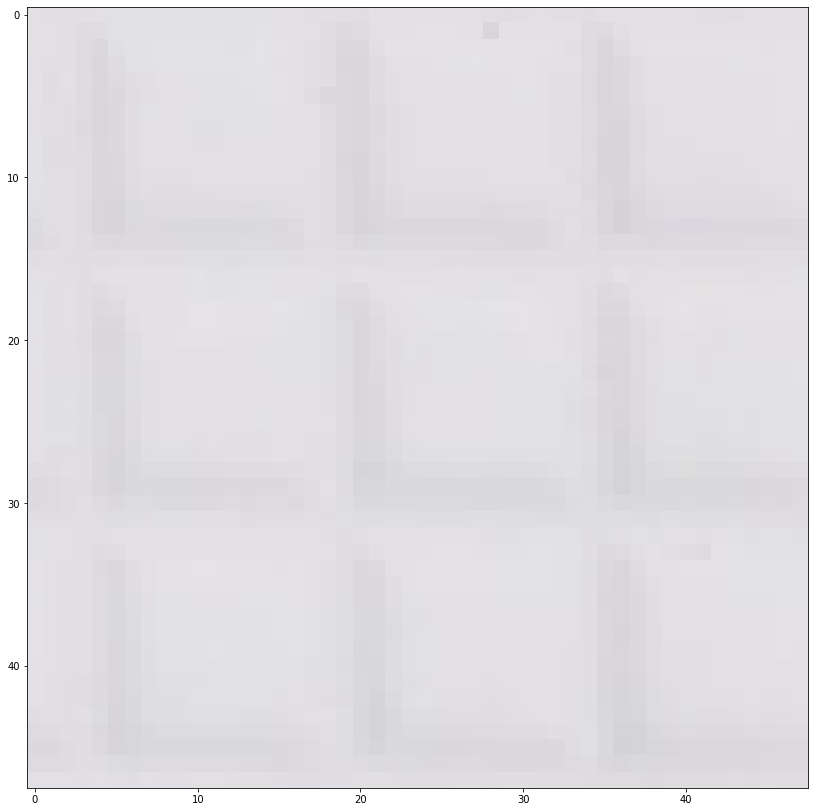

In [10]:
# max_clust = max(clusters, key=len)
# max_clust = np.random.choice(clusters)
max_clust = clusters[0]
rand_clust = np.random.choice(max_clust, 5, replace=False)


# images_id = indexImg[rand_clust]
# print (rand_clust, images_id)

# fig = plt.figure()
# plt.rcParams['figure.figsize'] = [5, 5]

for patch_num, patch in enumerate(rand_clust):
  image_id = indexImg[patch]
  first_patch = np.where(indexImg == image_id)[0][0]
  num_patch = patch-first_patch+1
  
  patches = sample_images(imageDict[image_id], conf_patchSize)

  k = 1 
  for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
      if k == num_patch:
        # ax1 = fig.add_subplot(1,5,patch_num+1)
        plt.imshow(patches[i][j][0]/256)
        plt.show()
      k += 1

Store patches in a directory

In [0]:
for cluster_num, cluster in enumerate(clusters):
  cluster = np.random.choice(cluster, 10, replace=False)
  for patch_num, patch in enumerate(cluster):
    image_id = indexImg[patch]
    first_patch = np.where(indexImg == image_id)[0][0]
    num_patch = patch-first_patch+1
    
    patches = sample_images(imageDict[image_id], conf_patchSize)

    k = 1 
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        if k == num_patch:
          I = patches[i][j][0]/256
          I_path = Path(conf_results+ str(cluster_num)+ "/" + str(patch_num) + ".png")
          if not I_path.parent.is_dir():
            I_path.parent.mkdir(parents=True)
          with I_path.open('wb') as f:
            plt.imsave(f, I)
        k += 1  

In [0]:
a= np.array([1,1,1,1,2,2,2,3,3,3,3,4,4,5,5,5,5])
np.where(a==2)

(array([4, 5, 6]),)

In [0]:
with open(ROOT+'output/test_dataset/rule.txt', 'r') as f:
  print (len(f.readlines()))

9385
